## 6.10 Homework

The goal of this homework is to create a tree-based regression model for prediction apartment prices (column `'price'`).

In this homework we'll again use the New York City Airbnb Open Data dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)
or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv)
if you don't want to sign up to Kaggle.

Let's load the data:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv'

!wget $data -O AB_NYC_2019.csv

--2021-10-15 23:57:35--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7077973 (6.8M) [text/plain]
Saving to: ‘AB_NYC_2019.csv’

AB_NYC_2019.csv     100%[===================>]   6.75M  5.07MB/s    in 1.3s    

2021-10-15 23:57:37 (5.07 MB/s) - ‘AB_NYC_2019.csv’ saved [7077973/7077973]



In [78]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv('AB_NYC_2019.csv', usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)

* Apply the log tranform to `price`
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1

In [7]:
from sklearn.model_selection import train_test_split

df.price = np.log1p(df.price)

df_full_train, df_test = train_test_split(
    df, 
    test_size=0.2, 
    random_state=1
)
df_train, df_val = train_test_split(
    df_full_train, 
    test_size=0.25, 
    random_state=1
)

In [8]:
len(df_train), len(df_val), len(df_test)

(29337, 9779, 9779)

In [9]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [30]:
y_train = df_train.price
del df_train['price']
y_val = df_val.price
del df_val['price']
y_test = df_test.price
del df_test['price']

Now, use `DictVectorizer` to turn train and validation into matrices:

In [32]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

In [33]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [34]:
from sklearn.tree import export_text

print(export_text(dt, feature_names=dv.get_feature_names()))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [1.66]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [1.81]



/home/fool/anaconda3/envs/ml-zoomcamp/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Which feature is used for splitting the data?

* **`room_type`**
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [36]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [44]:
from sklearn.metrics import mean_squared_error

y_pred = rf.predict(X_val)
mean_squared_error(np.expm1(y_val), np.expm1(y_pred), squared=False).round(4)

0.4602

What's the RMSE of this model on validation?

* 0.059
* 0.259
* 0.459
* 0.659

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

In [45]:
outcome = []

for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, 
                random_state=1,
                n_jobs=-1)
        
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        mse = mean_squared_error(np.expm1(y_val), np.expm1(y_pred), squared=False).round(4)

        outcome.append((n, mse))

In [52]:
df_outcome = pd.DataFrame(outcome, columns=['n_estimators', 'mse'])
df_outcome

,n_estimators,mse
0,10,0.4602
1,20,0.4474
2,30,0.4443
3,40,0.4423
4,50,0.4412
5,60,0.4411
6,70,0.4408
7,80,0.4409
8,90,0.4406
9,100,0.4404


After which value of `n_estimators` does RMSE stop improving?

- **10**
- 50
- 70
- 120

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [56]:
outcome = []

for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n,
            max_depth=d,
            random_state=1,
            n_jobs=-1)

        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        mse = mean_squared_error(np.expm1(y_val), np.expm1(y_pred), squared=False).round(4)

        outcome.append((d, n, mse))

In [57]:
df_outcome = pd.DataFrame(outcome, 
    columns=['max_depth', 'n_estimators', 'mse'])
df_outcome

,max_depth,n_estimators,mse
0,10,10,0.4475
1,10,20,0.4433
2,10,30,0.4420
3,10,40,0.4416
4,10,50,0.4413
...,...,...,...
75,25,160,0.4390
76,25,170,0.4388
77,25,180,0.4387
78,25,190,0.4386


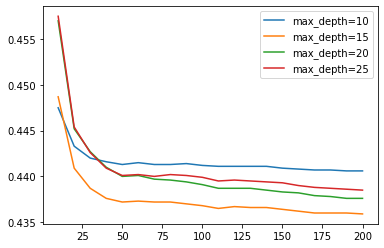

In [60]:
for d in [10, 15, 20, 25]:
    df_subset = df_outcome[df_outcome.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.mse,
        label='max_depth=%d' % d)

plt.legend()

What's the best `max_depth`:

* 10
* **15**
* 20
* 25

Bonus question (not graded):

Will the answer be different if we change the seed for the model?

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [62]:
rf = RandomForestRegressor(n_estimators=10,
            max_depth=20,
            random_state=1,
            n_jobs=-1)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
mse = mean_squared_error(np.expm1(y_val), np.expm1(y_pred), squared=False).round(4)
mse

0.457

In [84]:
rf.feature_importances_


array([7.44169335e-02, 3.34855282e-02, 1.41952590e-01, 1.48148321e-01,
       5.13897004e-02, 3.04777288e-04, 9.34469396e-04, 3.84337097e-02,
       1.20339211e-03, 6.80813317e-05, 4.23830217e-02, 5.84383522e-02,
       3.96990826e-01, 5.72304147e-03, 6.12725556e-03])

<BarContainer object of 15 artists>

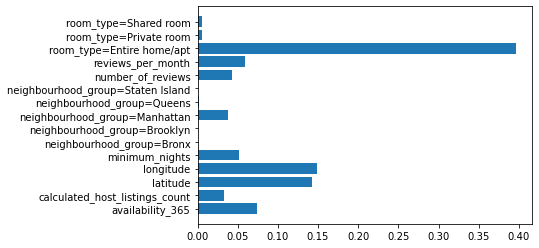

In [95]:
plt.barh(dv.get_feature_names(), rf.feature_importances_)


What's the most important feature? 

* `neighbourhood_group=Manhattan`
* **`room_type=Entire home/apt`**	
* `longitude`
* `latitude`

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

In [96]:
!pip install xgboost

In [97]:
import xgboost as xgb

features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [101]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100)

y_pred = model.predict(dval)
mean_squared_error(np.expm1(y_val), np.expm1(y_pred), squared=False).round(4)

0.4358

Now change `eta` first to `0.1` and then to `0.01`

In [102]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100)

y_pred = model.predict(dval)
mean_squared_error(np.expm1(y_val), np.expm1(y_pred), squared=False).round(4)

0.4347

In [103]:
xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100)

y_pred = model.predict(dval)
mean_squared_error(np.expm1(y_val), np.expm1(y_pred), squared=False).round(4)

2.1877

What's the best eta?

* 0.3
* **0.1**
* 0.01

## Submit the results


Submit your results here: https://forms.gle/wQgFkYE6CtdDed4w8

It's possible that your answers won't match exactly. If it's the case, select the closest one.


## Deadline


The deadline for submitting is 20 October 2021, 17:00 CET (Wednesday). After that, the form will be closed.

